2.RANDOM FOREST

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [2]:
ticker = input("Enter Stock Symbol (e.g. AAPL, TSLA, INFY.NS): ")
data = yf.download(ticker, period="2y", interval="1d")
data.dropna(inplace=True)
data.tail()


C:\Users\AFNAN PASHA\AppData\Local\Temp\ipykernel_5948\3944132311.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period="2y", interval="1d")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GAIL.NS,GAIL.NS,GAIL.NS,GAIL.NS,GAIL.NS
Date,,,,,
2025-11-03,183.690002,184.440002,177.839996,182.440002,11050075
2025-11-04,181.619995,184.490005,180.750000,183.979996,11320462
2025-11-05,181.619995,181.619995,181.619995,181.619995,0
2025-11-06,178.979996,182.800003,178.649994,182.800003,8609714
2025-11-07,179.619995,179.889999,177.160004,178.300003,2071100


In [3]:
df = data.copy()

df['Prev_Close'] = df['Close'].shift(1)
df['Prev_Volume'] = df['Volume'].shift(1)
df['Return'] = df['Close'].pct_change()
df['MA_5'] = df['Close'].rolling(5).mean()
df['MA_10'] = df['Close'].rolling(10).mean()
df['Volatility'] = df['Close'].rolling(5).std()
df['High_Low_Range'] = df['High'] - df['Low']
df['Day'] = df.index.day
df['Month'] = df.index.month
df['DayOfWeek'] = df.index.dayofweek

df.dropna(inplace=True)

X = df[['Prev_Close','Open','High','Low','Volume','Prev_Volume',
        'Return','MA_5','MA_10','Volatility','High_Low_Range',
        'Day','Month','DayOfWeek']]
y = df['Close']


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [5]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 10, 12, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=15,
    scoring='r2',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train_scaled, y_train)
best_rf = search.best_estimator_
print("✅ Best RF Params:", search.best_params_)


Fitting 3 folds for each of 15 candidates, totalling 45 fits


c:\Users\AFNAN PASHA\.anaconda\Anaconda compiler\envs\tf_new\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
18 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\AFNAN PASHA\.anaconda\Anaconda compiler\envs\tf_new\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\AFNAN PASHA\.anaconda\Anaconda compiler\envs\tf_new\lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "c:\Users\AFNAN PASHA\.anaconda\Anaconda compiler\envs\tf_new\lib\site-

✅ Best RF Params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 12}


In [6]:
y_pred = best_rf.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test.values - y_pred) / y_test.values)) * 100
acc = 100 - mape

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {acc:.2f}%")


R²: 0.7885
RMSE: 2.3860
MAE: 1.8250
MAPE: 3.54%
Accuracy: 96.46%


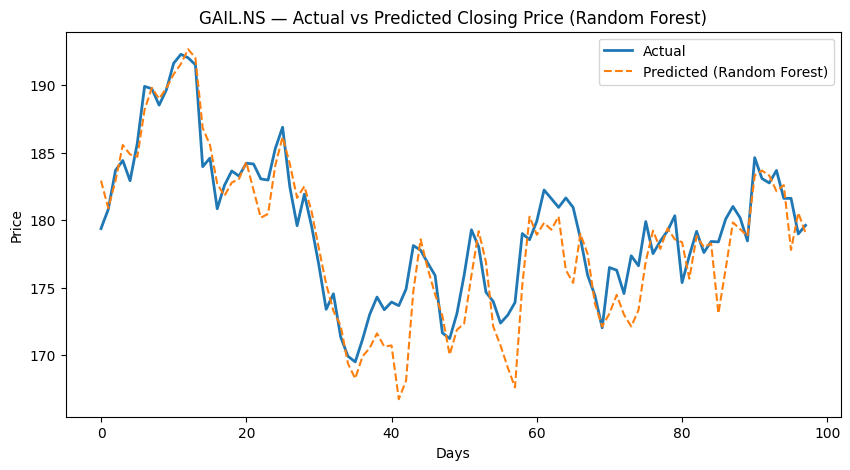

In [7]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted (Random Forest)', linestyle='dashed')
plt.title(f"{ticker} — Actual vs Predicted Closing Price (Random Forest)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()


In [8]:
latest = df.iloc[-1:]
latest_scaled = scaler.transform(latest[X.columns])
today_pred = best_rf.predict(latest_scaled)[0]

tomorrow_input = latest.copy()
tomorrow_input['Prev_Close'] = today_pred
tomorrow_scaled = scaler.transform(tomorrow_input[X.columns])
tomorrow_pred = best_rf.predict(tomorrow_scaled)[0]

print(f"\n📅 Predicted Closing Price:")
print(f"Today's Close:  {today_pred:.2f}")
print(f"Tomorrow's Close: {tomorrow_pred:.2f}")



📅 Predicted Closing Price:
Today's Close:  179.06
Tomorrow's Close: 179.06
